In [4]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap dask

Dataset Shape: (885129, 9)

First Few Rows:
                event_time event_type  product_id          category_id  \
0  2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1  2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
2  2020-09-24 11:57:27 UTC       view      215454  2144415927158964449   
3  2020-09-24 11:57:33 UTC       view      635807  2144415923107266682   
4  2020-09-24 11:57:36 UTC       view     3658723  2144415921169498184   

                   category_code        brand   price              user_id  \
0          electronics.telephone          NaN   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2                            NaN          NaN    9.81  1515915625513238515   
3  computers.peripherals.printer       pantum  113.81  1515915625519014356   
4                            NaN  cameronsino   15.87  1515915625510743344   

  user_session  
0   LJuJVLEjPT  
1   tdic

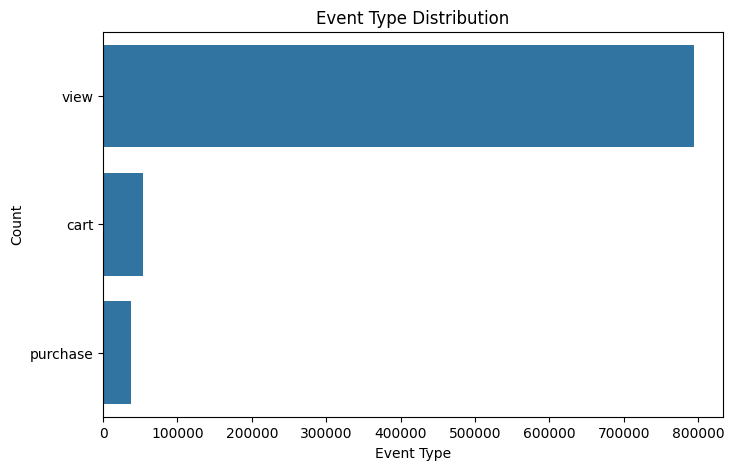

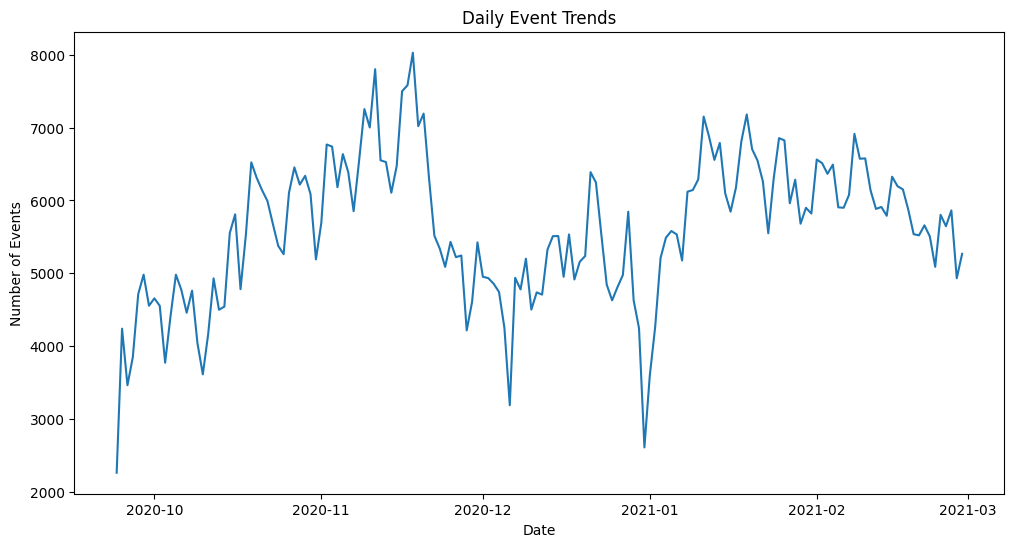

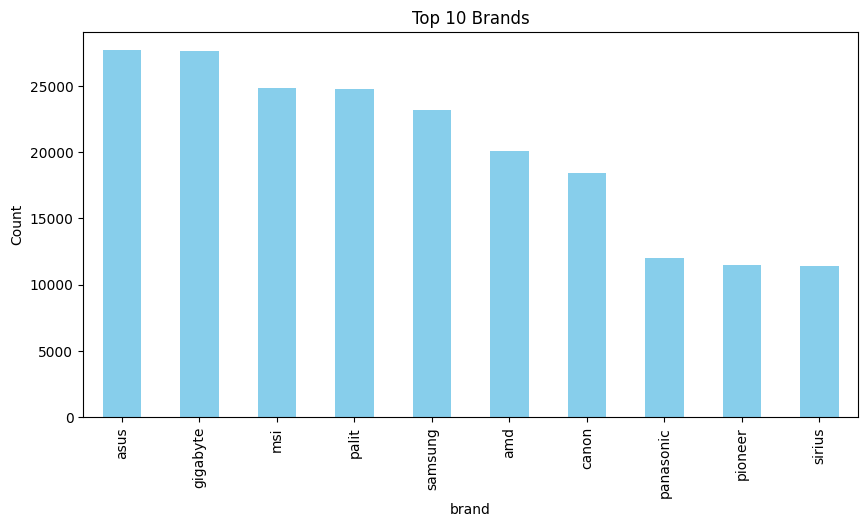

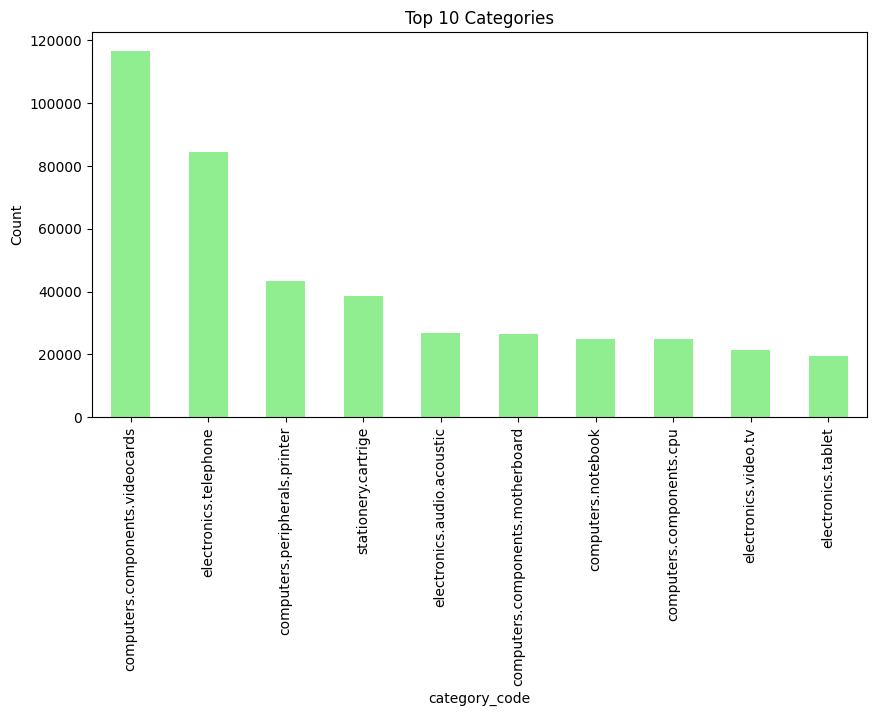

In [ ]:
# Owner : Poulomi Bhattacharya

# Step 1: Install Required Libraries
# Uncomment this section when running on Google Colab
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap

# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
import shap

# Step 3: Load Dataset
file_path = '/content/events.csv'  # Update the path for your environment
data = pd.read_csv(file_path)

# Step 4: Initial Data Inspection
print("Dataset Shape:", data.shape)
print("\nFirst Few Rows:")
print(data.head())

print("\nData Info:")
data.info()

print("\nMissing Values:")
print(data.isnull().sum())

# Step 5: Exploratory Data Analysis (EDA)

# Event type distribution (Bar Plot)
plt.figure(figsize=(8, 5))
sns.countplot(data['event_type'], order=data['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

# Event trends over time (Line Plot)
data['event_time'] = pd.to_datetime(data['event_time'])
data.set_index('event_time', inplace=True)
event_trends = data['event_type'].resample('D').count()
plt.figure(figsize=(12, 6))
plt.plot(event_trends)
plt.title('Daily Event Trends')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

# Top brands (Bar Plot)
plt.figure(figsize=(10, 5))
data['brand'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Brands')
plt.ylabel('Count')
plt.show()

# Top categories (Bar Plot)
plt.figure(figsize=(10, 5))
data['category_code'].value_counts().head(10).plot(kind='bar', color='lightgreen')
plt.title('Top 10 Categories')
plt.ylabel('Count')
plt.show()

# Step 6: Define Churn
churn_threshold = data.index.max() - pd.Timedelta(days=30)
data['is_churned'] = data.index < churn_threshold

# Step 7: Feature Engineering
user_features = data.groupby('user_id').agg({
    'event_type': lambda x: x.value_counts().to_dict(),
    'price': ['sum', 'mean'],
    'brand': lambda x: x.mode()[0] if not x.mode().empty else 'unknown',
    'category_code': lambda x: x.mode()[0] if not x.mode().empty else 'unknown'
})
user_features.columns = ['_'.join(col).strip() for col in user_features.columns.values]
user_features.reset_index(inplace=True)

# Add churn labels
user_features['is_churned'] = user_features['user_id'].apply(
    lambda uid: uid in data[data['is_churned']].user_id.unique())

# Step 8: Train-Test Split
X = user_features.drop(columns=['user_id', 'is_churned'])
y = user_features['is_churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 9: Model Training
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

# Step 10: Evaluation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Step 11: Interpretability with SHAP
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Step 12: Advanced Visualization
# SHAP feature importance bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Pair plot for selected features
selected_features = ['price_sum', 'price_mean', 'event_type']
sns.pairplot(user_features[selected_features + ['is_churned']], hue='is_churned')
plt.show()

# Step 13: Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid,
                           cv=3,
                           scoring='roc_auc',
                           verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Step 14: Retrain with Best Parameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Step 15: Final Evaluation
y_final_pred = best_clf.predict(X_test)
y_final_pred_proba = best_clf.predict_proba(X_test)[:, 1]

print("Final Classification Report:")
print(classification_report(y_test, y_final_pred))

print("Final AUC Score:", roc_auc_score(y_test, y_final_pred_proba))

# Step 16: Recommendations
print("Analysis complete. Provide findings and integrate into business strategies.")

# Step 17: Data Visualization Updates

# Scatter plot for user features (Price vs. Event count)
if 'is_churned' not in user_features.columns:
    user_features['is_churned'] = user_features['user_id'].apply(
        lambda uid: uid in data[data['is_churned']].user_id.unique())

plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_features, x='price_sum', y='price_mean', hue='is_churned', palette='coolwarm', style='is_churned', markers=["o", "s"], s=100)
plt.title('Price Sum vs. Price Mean', fontsize=16)
plt.xlabel('Total Price', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.legend(title='Churned', loc='upper right')
plt.show()

# Bar plot for churn distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='is_churned', data=user_features, palette='pastel')
plt.title('Churn Distribution', fontsize=16)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Pie chart for churn distribution
churn_counts = user_features['is_churned'].value_counts()
plt.figure(figsize=(6, 6))
churn_counts.plot(kind='pie', labels=['Not Churned', 'Churned'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon'])
plt.title('Churn Rate Distribution', fontsize=16)
plt.ylabel('')
plt.show()

# Donut chart for churn distribution
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['Not Churned', 'Churned'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon'], wedgeprops={'width': 0.3})
plt.title('Churn Rate Distribution (Donut)', fontsize=16)
plt.show()
